<a href="https://colab.research.google.com/github/wangyouzhong/MLStudy/blob/master/Power_Prediction_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [39]:
import io
import pandas as pd

from google.colab import files

import numpy as np
from datetime import date, datetime, timedelta

In [5]:
uploaded3 = files.upload()

Saving L3.csv to L3 (1).csv


In [40]:
df = pd.read_csv(io.BytesIO(uploaded3['L3.csv']))

In [41]:
# add daily sum and time bucket ratio to daily sum as features
NUM_TIME_BUCKETS = 96
START_INDEX_FEATURES = NUM_TIME_BUCKETS

df.columns = ['Id', 'Date'] + [f'TB{i}' for i in range(1, NUM_TIME_BUCKETS+1)]
df['Date'] = pd.to_datetime(df['Date']).dt.date
df

,Id,Date,TB1,TB2,TB3,TB4,TB5,TB6,TB7,TB8,TB9,TB10,TB11,TB12,TB13,TB14,TB15,TB16,TB17,TB18,TB19,TB20,TB21,TB22,TB23,TB24,TB25,TB26,TB27,TB28,TB29,TB30,TB31,TB32,TB33,TB34,TB35,TB36,TB37,TB38,...,TB57,TB58,TB59,TB60,TB61,TB62,TB63,TB64,TB65,TB66,TB67,TB68,TB69,TB70,TB71,TB72,TB73,TB74,TB75,TB76,TB77,TB78,TB79,TB80,TB81,TB82,TB83,TB84,TB85,TB86,TB87,TB88,TB89,TB90,TB91,TB92,TB93,TB94,TB95,TB96
0,139251010000000953,2019-01-01,139.439663,127.302321,119.790183,117.782535,110.260393,101.934291,97.396438,96.698862,95.846770,95.182846,92.004688,88.092131,91.283209,90.177244,88.708021,88.442411,85.504668,84.942266,86.092679,87.014330,86.865461,85.355015,82.347779,78.112053,68.876353,73.729268,66.992975,65.620344,64.767651,78.708633,92.117877,105.813547,126.851638,137.130221,153.292620,172.887920,216.338086,216.499677,...,260.604390,260.794296,261.618119,260.410437,256.860222,258.367665,259.267954,255.889186,256.234454,251.733526,253.060736,169.000653,174.316712,178.301884,177.104918,171.312698,164.677503,162.545790,163.696737,170.815170,165.797771,167.774777,162.219537,166.467952,170.952205,176.889430,185.207906,181.386608,181.008994,181.457673,184.951047,187.337285,190.128226,184.331248,183.509355,176.219448,167.887276,158.470484,150.323493,143.850835
1,139251010000000953,2019-01-02,120.503845,117.349021,110.657592,102.906791,103.578353,90.618594,89.428853,83.373523,96.313959,90.506790,92.492857,78.305366,91.674901,87.175032,82.627243,87.706742,84.360357,83.647233,86.047044,83.175134,92.065731,89.871075,84.637154,90.381289,72.573163,79.663929,69.019778,67.859454,73.255503,78.492847,90.429719,100.659709,118.499355,130.062418,144.834197,167.569256,207.189862,219.122800,...,262.614308,263.173392,263.352288,263.732740,260.200462,259.552441,261.542219,257.306632,257.454331,250.630975,246.677790,173.395331,173.247478,179.119319,181.130723,172.431674,167.940838,163.201839,159.947323,165.188458,158.381998,163.432975,151.094304,158.090667,159.554482,164.175128,174.279432,170.459428,168.864455,170.290711,169.613266,171.382665,161.363754,152.990980,146.391072,150.247456,143.614168,135.241240,131.278230,122.201884
2,139251010000000953,2019-01-03,119.054411,113.461381,109.019129,102.248235,101.466245,87.126290,85.859366,80.224715,91.601489,87.108466,88.682241,74.384253,87.881483,83.204543,78.936998,84.494518,80.957722,79.953258,82.375262,81.558745,88.962151,85.227929,78.232573,79.070992,54.730192,67.096449,63.967903,66.788699,76.866217,79.612888,87.088226,98.711508,115.094744,129.628182,145.498866,166.778137,205.384494,209.352973,...,208.367383,207.529761,206.938062,207.605235,205.509613,215.405268,226.547457,233.157517,243.354039,243.849967,246.386159,160.415138,165.446026,171.687940,172.159325,167.239343,166.621991,155.375629,146.709297,153.780523,145.743225,149.150742,138.501170,146.525020,148.044261,156.138623,169.157942,162.477838,162.238434,160.321249,161.024958,166.956953,165.855017,155.794104,155.492025,156.603946,147.835247,138.821851,133.105765,122.270591
3,139251010000000953,2019-01-04,121.080167,113.375990,112.855542,112.263716,107.237621,97.188355,94.691173,92.981108,95.760831,95.466939,93.820803,85.386824,92.261988,90.539492,87.811163,92.120636,88.442304,88.398431,88.401106,90.271867,91.619799,88.822257,85.389676,80.474389,62.751993,77.466720,83.806728,88.117124,98.220487,100.171264,104.880383,118.865171,135.505606,150.192440,162.089711,173.369439,197.371696,199.036141,...,185.176432,180.943482,178.127137,176.190525,172.771066,180.861096,190.123138,196.568212,207.176153,212.097792,221.633227,167.085154,173.514412,169.560842,162.695647,158.189749,161.720424,151.046653,141.837362,147.514554,142.901668,139.832138,139.984529,144.578787,152.116200,160.571161,172.932789,166.061648,163.764600,161.521083,162.501107,168.163179,170.013237,159.148580,166.698746,160.067192,150.799625,143.134452,135.886696,127.650203
4,139251010000000953,2019-01-05,105.965670,100.102905,91.755365,86.466442,82.576150,75.976198,72.498847,69.908311,73.935389,70.05197

In [45]:
df_d1 = pd.DataFrame.copy(df_l3)
df_d1['Date'] = df_d1['Date'] + pd.Timedelta(days=1)
df_d2 = pd.DataFrame.copy(df_l3)
df_d2['Date'] = df_d1['Date'] + pd.Timedelta(days=2)
df_join = df_d2.set_index(['Id', 'Date']).join(
    df_d1.set_index(['Id', 'Date']).join(df_l3.set_index(['Id', 'Date']), lsuffix=f'_d1'),
    lsuffix=f'_d2').reset_index()
df_join


,Id,Date,TB1_d2,TB2_d2,TB3_d2,TB4_d2,TB5_d2,TB6_d2,TB7_d2,TB8_d2,TB9_d2,TB10_d2,TB11_d2,TB12_d2,TB13_d2,TB14_d2,TB15_d2,TB16_d2,TB17_d2,TB18_d2,TB19_d2,TB20_d2,TB21_d2,TB22_d2,TB23_d2,TB24_d2,TB25_d2,TB26_d2,TB27_d2,TB28_d2,TB29_d2,TB30_d2,TB31_d2,TB32_d2,TB33_d2,TB34_d2,TB35_d2,TB36_d2,TB37_d2,TB38_d2,...,TB57,TB58,TB59,TB60,TB61,TB62,TB63,TB64,TB65,TB66,TB67,TB68,TB69,TB70,TB71,TB72,TB73,TB74,TB75,TB76,TB77,TB78,TB79,TB80,TB81,TB82,TB83,TB84,TB85,TB86,TB87,TB88,TB89,TB90,TB91,TB92,TB93,TB94,TB95,TB96
0,139251010000000953,2019-01-04,139.439663,127.302321,119.790183,117.782535,110.260393,101.934291,97.396438,96.698862,95.846770,95.182846,92.004688,88.092131,91.283209,90.177244,88.708021,88.442411,85.504668,84.942266,86.092679,87.014330,86.865461,85.355015,82.347779,78.112053,68.876353,73.729268,66.992975,65.620344,64.767651,78.708633,92.117877,105.813547,126.851638,137.130221,153.292620,172.887920,216.338086,216.499677,...,185.176432,180.943482,178.127137,176.190525,172.771066,180.861096,190.123138,196.568212,207.176153,212.097792,221.633227,167.085154,173.514412,169.560842,162.695647,158.189749,161.720424,151.046653,141.837362,147.514554,142.901668,139.832138,139.984529,144.578787,152.116200,160.571161,172.932789,166.061648,163.764600,161.521083,162.501107,168.163179,170.013237,159.148580,166.698746,160.067192,150.799625,143.134452,135.886696,127.650203
1,139251010000000953,2019-01-05,120.503845,117.349021,110.657592,102.906791,103.578353,90.618594,89.428853,83.373523,96.313959,90.506790,92.492857,78.305366,91.674901,87.175032,82.627243,87.706742,84.360357,83.647233,86.047044,83.175134,92.065731,89.871075,84.637154,90.381289,72.573163,79.663929,69.019778,67.859454,73.255503,78.492847,90.429719,100.659709,118.499355,130.062418,144.834197,167.569256,207.189862,219.122800,...,213.816471,212.354532,212.044959,209.876146,205.785208,204.174900,202.210582,197.883338,196.765659,194.937442,199.705543,146.997571,149.877208,149.409897,145.343126,139.917253,133.280887,135.290267,139.268966,145.233556,142.589052,146.036964,142.429026,147.651855,153.447582,159.910535,169.542790,168.359551,167.852225,168.971672,170.418985,169.853306,167.133301,160.006060,152.007337,147.060011,138.041396,127.561116,120.735603,112.255813
2,139251010000000953,2019-01-06,119.054411,113.461381,109.019129,102.248235,101.466245,87.126290,85.859366,80.224715,91.601489,87.108466,88.682241,74.384253,87.881483,83.204543,78.936998,84.494518,80.957722,79.953258,82.375262,81.558745,88.962151,85.227929,78.232573,79.070992,54.730192,67.096449,63.967903,66.788699,76.866217,79.612888,87.088226,98.711508,115.094744,129.628182,145.498866,166.778137,205.384494,209.352973,...,234.937747,231.418619,228.789198,225.491401,219.502831,221.578048,223.986592,223.096563,225.975580,223.169991,226.176978,163.062372,167.501747,170.377385,170.103222,164.890632,162.070590,162.503550,164.855752,173.306951,171.548207,173.759186,168.529624,173.200158,178.108721,183.704867,193.125190,189.540347,186.807804,187.606575,186.687995,185.425205,175.336742,165.560103,159.462675,154.280202,144.456001,134.385936,126.443107,117.613147
3,139251010000000953,2019-01-07,121.080167,113.375990,112.855542,112.263716,107.237621,97.188355,94.691173,92.981108,95.760831,95.466939,93.820803,85.386824,92.261988,90.539492,87.811163,92.120636,88.442304,88.398431,88.401106,90.271867,91.619799,88.822257,85.389676,80.474389,62.751993,77.466720,83.806728,88.117124,98.220487,100.171264,104.880383,118.865171,135.505606,150.192440,162.089711,173.369439,197.371696,199.036141,...,239.689458,240.958774,243.016835,245.609513,244.694682,245.602745,247.832626,244.475394,247.756828,247.855043,253.479846,181.284356,189.391918,185.865422,179.559789,172.398266,172.588707,165.019575,160.793624,169.643292,167.144233,167.305448,164.249829,170.199763,177.424005,185.282071,197.599689,190.957764,187.250701,186.286020,184.294970,186.045574,176.917256,164.568706,165.860622,160.600165,150.034889,142.009153,134.632629,125.673484
4,1392510100000009

In [46]:
TRAIN_DS_START = datetime(2019, 1, 10, 0, 0, 0)
TRAIN_DS_END = datetime(2019, 3, 10, 23, 59, 59)
VALIDATE_DS_START = datetime(2019, 3, 11, 0, 0, 0)
VALIDATE_DS_END = datetime(2019, 3, 31, 23, 59, 59)

df_train = df_join[((df_join['Date'] >= pd.Timestamp(TRAIN_DS_START)) & (df_join['Date'] <= pd.Timestamp(TRAIN_DS_END)))]
df_validate = df_join[((df_join['Date'] >= pd.Timestamp(VALIDATE_DS_START)) & (df_join['Date'] <= pd.Timestamp(VALIDATE_DS_END)))]


In [47]:
df_train

,Id,Date,TB1_d2,TB2_d2,TB3_d2,TB4_d2,TB5_d2,TB6_d2,TB7_d2,TB8_d2,TB9_d2,TB10_d2,TB11_d2,TB12_d2,TB13_d2,TB14_d2,TB15_d2,TB16_d2,TB17_d2,TB18_d2,TB19_d2,TB20_d2,TB21_d2,TB22_d2,TB23_d2,TB24_d2,TB25_d2,TB26_d2,TB27_d2,TB28_d2,TB29_d2,TB30_d2,TB31_d2,TB32_d2,TB33_d2,TB34_d2,TB35_d2,TB36_d2,TB37_d2,TB38_d2,...,TB57,TB58,TB59,TB60,TB61,TB62,TB63,TB64,TB65,TB66,TB67,TB68,TB69,TB70,TB71,TB72,TB73,TB74,TB75,TB76,TB77,TB78,TB79,TB80,TB81,TB82,TB83,TB84,TB85,TB86,TB87,TB88,TB89,TB90,TB91,TB92,TB93,TB94,TB95,TB96
6,139251010000000953,2019-01-10,120.091600,112.394770,109.466327,106.726101,103.062579,92.954940,91.001536,88.121097,93.173251,91.371656,90.452688,80.836998,89.051066,86.598574,83.631020,87.904772,84.460718,84.602641,85.142214,85.838349,89.005799,87.171587,83.985590,82.435311,65.839103,80.820288,84.240872,88.338530,100.161217,102.978990,110.514870,126.076537,146.815487,162.927558,175.123330,189.907511,220.765485,226.010222,...,231.343864,228.876513,226.140126,223.605117,218.529731,225.908039,233.706368,237.634801,244.900988,246.641838,248.924398,171.191745,172.720534,172.343578,166.520939,158.672225,157.103805,155.211937,153.301568,165.322947,163.723137,163.291773,154.247705,159.088522,160.643785,166.455385,177.604429,170.091862,166.837841,165.921596,165.681106,169.484005,164.113750,153.679639,152.746621,152.452913,143.921637,135.615386,130.276077,120.533316
7,139251010000000953,2019-01-11,121.203910,115.670644,109.266418,103.767527,100.894564,90.616895,87.937824,84.330188,91.413088,87.483956,87.672644,78.086405,86.434389,83.606693,80.242804,83.334960,80.530323,80.131585,81.970560,80.271946,85.406461,83.730597,79.344156,79.952245,65.914960,76.467668,75.350074,79.766510,89.081600,95.636833,104.207817,115.459153,130.433051,139.658582,152.920405,168.794373,202.343264,204.045640,...,228.565009,223.899002,218.296279,214.734727,208.030296,216.765849,226.925872,232.605415,243.187412,242.148574,242.227311,156.466122,163.163127,172.207887,176.479574,176.491515,188.257693,175.078683,163.934015,175.029054,172.267172,167.643712,160.665875,164.187213,165.785369,172.713833,184.025662,174.288184,169.755996,167.889416,165.296907,170.294053,157.720906,144.090108,153.279116,149.940303,141.318190,135.521380,127.899886,119.619825
8,139251010000000953,2019-01-12,113.214296,104.456613,101.942971,100.185147,95.829800,86.415940,84.066633,82.062817,85.095069,84.269018,82.724471,75.062749,82.177835,79.521987,76.866153,80.078460,76.199916,75.836028,75.354453,77.086034,78.951050,79.506779,80.817308,80.860222,69.385040,83.083415,81.797261,81.758394,91.850770,91.937943,97.451461,108.050553,123.951962,139.667198,150.660011,165.629974,195.021201,203.256784,...,238.785184,236.238738,233.946551,231.977271,227.678779,236.787664,247.008252,252.711780,262.386221,264.154006,268.971841,191.799255,198.174959,197.658529,193.908802,184.350890,181.277772,174.072004,166.816974,173.934194,167.533715,166.673493,159.272410,164.437151,167.652513,174.256400,185.334388,177.556385,175.172858,172.986033,173.916048,178.986775,178.903128,169.051922,173.045337,169.680036,161.035047,152.374268,145.125948,136.273659
9,139251010000000953,2019-01-13,116.229593,112.139335,108.189221,102.525197,101.426419,89.621010,88.139147,82.962634,92.709842,88.631999,89.887105,77.531503,89.080902,85.682945,81.979745,87.155243,83.923430,84.627017,86.475855,85.198829,92.289042,92.072857,89.647649,94.283751,75.552881,88.036701,83.854651,83.409904,90.739478,94.947456,104.319866,120.945698,141.270223,154.973720,169.720045,188.082619,222.558430,223.456689,...,266.150940,264.758099,263.231882,260.276565,252.912476,250.836643,249.360698,243.264470,242.995965,247.743216,255.916812,185.515136,196.630660,196.150784,194.352170,183.165437,179.817566,172.018121,164.857277,173.112383,165.966988,168.218027,154.562842,162.864624,162.428790,172.652108,188.846130,180.465598,177.135569,176.303894,174.804727,180.233011,171.694432,158.052005,155.293394,160.457174,150.696618,140.133288,133.993274,120.131035
10,1392510100000

In [83]:
def split_feature_labels(df):
  x = df.iloc[:,2:2+96*2].values
  y = df.iloc[:,2+96:].values
  x = x.reshape([x.shape[0], x.shape[1], 1])
  y = y.reshape([y.shape[0], y.shape[1], 1])
  print(x.shape, y.shape)
  return (x, y)
x_train, y_train = split_feature_labels(df_train)
x_validate, y_validate = split_feature_labels(df_validate)



(5760, 192, 1) (5760, 192, 1)
(2016, 192, 1) (2016, 192, 1)


# Build A DNN Model 

In [88]:
import tensorflow as tf 
keras = tf.keras

BATCH_SIZE = 128

In [85]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
# keras.layers.Lambda(lambda x: x * 200)
print(model.summary())
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(x_train, y_train, epochs=100, batch_size = BATCH_SIZE, callbacks=[lr_schedule])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 1)           3

(1e-08, 0.1, 0.0, 200.0)

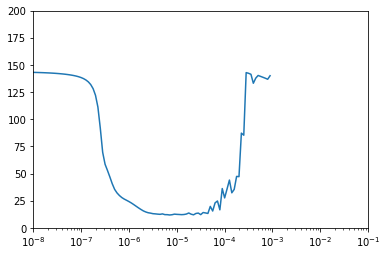

In [86]:
import matplotlib.pyplot as plt
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-1, 0, 200])

In [87]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=1e-5)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=30)
history = model.fit(x_train, y_train, epochs=500, batch_size = BATCH_SIZE,
                    validation_data=(x_validate, y_validate),
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
180/180 [==============================] - 1s 5ms/step - loss: 141.5685 - mae: 142.0655 - val_loss: 221.3610 - val_mae: 221.8584
Epoch 2/500
180/180 [==============================] - 1s 4ms/step - loss: 136.4546 - mae: 136.9514 - val_loss: 208.7055 - val_mae: 209.2028
Epoch 3/500
180/180 [==============================] - 1s 4ms/step - loss: 125.4195 - mae: 125.9153 - val_loss: 186.7013 - val_mae: 187.1968
Epoch 4/500
180/180 [==============================] - 1s 5ms/step - loss: 110.2359 - mae: 110.7313 - val_loss: 159.5392 - val_mae: 160.0354
Epoch 5/500
180/180 [==============================] - 1s 5ms/step - loss: 91.7898 - mae: 92.2848 - val_loss: 130.6047 - val_mae: 131.1007
Epoch 6/500
180/180 [==============================] - 1s 4ms/step - loss: 75.2655 - mae: 75.7591 - val_loss: 108.9251 - val_mae: 109.4217
Epoch 7/500
180/180 [==============================] - 1s 4ms/step - loss: 63.7396 - mae: 64.2335 - val_loss: 94.9938 - val_mae: 95.4904
Epoch 8/500
180/180 [

In [89]:
model = keras.models.load_model("my_checkpoint.h5")

# Evaluate the Model


In [90]:
# Model prediction
y_validate_predict = model.predict(x_validate, batch_size = BATCH_SIZE)


In [91]:
y_validate

array([[[ 262.60363892],
        [ 249.93713294],
        [ 234.60702694],
        ...,
        [ 317.76440138],
        [ 304.78082731],
        [ 279.41484136]],

       [[ 270.11883303],
        [ 254.35502113],
        [ 245.62291826],
        ...,
        [ 267.54359526],
        [ 258.4828546 ],
        [ 238.56964773]],

       [[ 231.32549766],
        [ 224.31923403],
        [ 216.39464229],
        ...,
        [ 271.4049126 ],
        [ 257.60416927],
        [ 242.21663477]],

       ...,

       [[3011.48117547],
        [2823.14683742],
        [2576.81068986],
        ...,
        [3632.94330977],
        [3451.19262155],
        [3286.45447623]],

       [[3116.42062915],
        [2924.47934063],
        [2670.00708981],
        ...,
        [3522.56217674],
        [3343.92062619],
        [3187.72090194]],

       [[3021.76150975],
        [2830.59455822],
        [2587.98764644],
        ...,
        [3508.08216912],
        [3330.90424703],
        [3172.25482965]]

In [92]:
y_validate_predict

array([[[ 258.00983],
        [ 227.30907],
        [ 245.8873 ],
        ...,
        [ 308.65598],
        [ 301.15256],
        [ 277.06537]],

       [[ 265.4553 ],
        [ 220.65411],
        [ 249.74399],
        ...,
        [ 313.034  ],
        [ 312.91602],
        [ 282.66592]],

       [[ 264.22714],
        [ 220.2892 ],
        [ 245.39342],
        ...,
        [ 267.27133],
        [ 264.02856],
        [ 239.42964]],

       ...,

       [[3210.8071 ],
        [2640.9902 ],
        [2871.1912 ],
        ...,
        [3510.9617 ],
        [3395.6907 ],
        [3195.3606 ]],

       [[3153.911  ],
        [2595.292  ],
        [2815.4724 ],
        ...,
        [3634.538  ],
        [3515.222  ],
        [3306.5347 ]],

       [[3023.191  ],
        [2481.2383 ],
        [2691.1914 ],
        ...,
        [3524.1934 ],
        [3406.169  ],
        [3207.578  ]]], dtype=float32)

In [98]:
import matplotlib.pyplot as plt

def plot_validate_data(i):
  x = list(range(1, NUM_TIME_BUCKETS+1))
  y1 = y_validate_predict[i].flatten()[96:]
  y0 = y_validate[i].flatten()[96:]
  print('nmae:', np.mean(np.abs(y0-y1)) / (max(y0) - min(y0)))
  plt.plot(x, y1, 'r', label = 'true data')
  plt.plot(x, y0, 'b', label = 'predicted data')
  plt.legend()
  plt.show()

In [96]:
y_validate.shape

(2016, 192, 1)

In [95]:
y_validate_predict.shape

(2016, 192, 1)

nmae: 0.10636900770728208


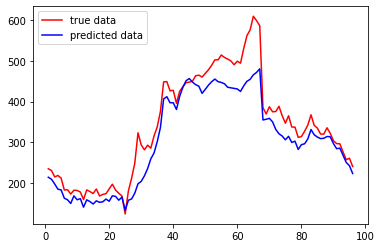

In [106]:
plot_validate_data(9)

In [108]:
nmae = np.mean(
    [np.mean(np.abs(y0.flatten()[96:]-y1.flatten()[96:])) / (max(y0.flatten()[96:]) - min(y0.flatten()[96:]))  for y0, y1 in zip(y_validate, y_validate_predict)]
)

In [109]:
nmae

0.08195195004796108

# Save Predicted Results

In [ ]:
output_file_name = 'predicted_L3_data.csv'
output_data = pd.DataFrame.copy(validate_data.iloc[:,:96])

output_data.iloc[:,:96] = denormalized_validated_y[:,:]
output_data.reset_index().set_index(['Id', 'Date']).reset_index().to_csv(output_file_name)
files.download(output_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>